In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

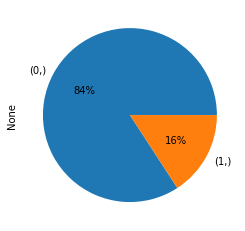

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Entrenando LGBM con hiperparámetros

In [4]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [5]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865319	training's binary_logloss: 0.285035	valid_1's auc: 0.85101	valid_1's binary_logloss: 0.296508
[200]	training's auc: 0.879707	training's binary_logloss: 0.273318	valid_1's auc: 0.854022	valid_1's binary_logloss: 0.294056
Early stopping, best iteration is:
[284]	training's auc: 0.88885	training's binary_logloss: 0.265847	valid_1's auc: 0.854905	valid_1's binary_logloss: 0.293443
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.864997	training's binary_logloss: 0.28516	valid_1's auc: 0.850819	valid_1's binary_logloss: 0.296441
[200]	training's auc: 0.879319	training's binary_logloss: 0.273464	valid_1's auc: 0.85398	valid_1's binary_logloss: 0.293806
Early stopping, best iteration is:
[281]	training's auc: 0.888196	training's binary_logloss: 0.266213	valid_1's auc: 0.854742	valid_1's binary_logloss: 0.29319
*********

In [7]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_1_saldoMean_ult1meses                       0.008535
PRODUCTO_1_saldoMax_ult1meses                        0.008169
edad                                                 0.008121
ubigeo_mode                                          0.007866
PRODUCTO_1_saldoSum_ult1meses                        0.005791
PRODUCTO_1_saldoMedian_ult1meses                     0.005591
sexo_0                                               0.004987
PRODUCTO_3_saldoUnique_ult12meses                    0.004789
estadocontribuyente_0                                0.004754
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.004300
PRODUCTO_0_saldoMin_ult12meses                       0.004208
cod_instit_financiera_10_saldoStd_ult1meses          0.004180
PRODUCTO_6_saldoSum_ult12meses                       0.004148
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.004094
PRODUCTO_4_saldoStd_ult12meses                       0.004014
PRODUCTO_3_saldoMean_ult1meses                       0.003921
PRODUCTO

In [8]:
fi.to_pickle('fi_lightgbm.pkl')

In [9]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Catboost con parametros casi estandar
### CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)

In [10]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7424907	test1: 0.7439484	best: 0.7439484 (0)	total: 871ms	remaining: 14m 29s
100:	test: 0.8471984	test1: 0.8422880	best: 0.8422880 (100)	total: 54.7s	remaining: 8m 6s
200:	test: 0.8576204	test1: 0.8475353	best: 0.8475353 (200)	total: 1m 47s	remaining: 7m 5s
300:	test: 0.8651702	test1: 0.8496751	best: 0.8496775 (299)	total: 2m 39s	remaining: 6m 11s
400:	test: 0.8713331	test1: 0.8509214	best: 0.8509214 (400)	total: 3m 30s	remaining: 5m 14s
500:	test: 0.8763042	test1: 0.8515765	best: 0.8515909 (498)	total: 4m 19s	remaining: 4m 18s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.851979197
bestIteration = 561

Shrink model to first 562 iterations.
********** 1 **********
Learning rate set to 0.128212
0:	test: 0.7257203	test1: 0.7278298	best: 0.7278298 (0)	total: 633ms	remaining: 10m 31s
100:	test: 0.8471016	test1: 0.8432364	best: 0.8432364 (100)	total: 58s	remaining: 8m 36s
200:	test: 0.8573899	test1: 0.848

In [12]:
fi.to_pickle('fi_catboost.pkl')

In [13]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Entrenamiento de modelo XgBoost

In [14]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [15]:
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = XGBClassifier(n_estimators=1000, booster='gbtree', colsample_bytree=0.8, 
                            subsample = 0.8, max_depth=4,  learning_rate=0.3)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.71867	validation_1-auc:0.72320
[100]	validation_0-auc:0.86630	validation_1-auc:0.84686
[159]	validation_0-auc:0.87726	validation_1-auc:0.84776
********** 1 **********
[0]	validation_0-auc:0.72019	validation_1-auc:0.71819
[100]	validation_0-auc:0.86656	validation_1-auc:0.84752
[112]	validation_0-auc:0.86884	validation_1-auc:0.84768
********** 2 **********
[0]	validation_0-auc:0.71867	validation_1-auc:0.72510
[100]	validation_0-auc:0.86763	validation_1-auc:0.85002
[175]	validation_0-auc:0.88030	validation_1-auc:0.85072
********** 3 **********
[0]	validation_0-auc:0.72175	validation_1-auc:0.72340
[100]	validation_0-auc:0.86695	validation_1-auc:0.84898
[130]	validation_0-auc:0.87246	validation_1-auc:0.84919
********** 4 **********
[0]	validation_0-auc:0.72201	validation_1-auc:0.70930
[100]	validation_0-auc:0.86989	validation_1-auc:0.84073
[143]	validation_0-auc:0.87738	validation_1-auc:0.84112
*********************
roc auc estimado:  0.8475722843014554
roc auc varian

In [16]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_12_saldoMin_ult1meses                      0.075974
RIESGO_DIRECTO_2_saldoMean_ult1meses                0.052980
RIESGO_DIRECTO_2_saldoMin_ult2meses                 0.045184
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult1meses    0.042137
COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses       0.022472
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses       0.020933
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses       0.020831
PRODUCTO_12_saldoMax_ult1meses                      0.017672
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult4meses    0.016055
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult4meses    0.015935
tipo_credito_11_saldoMean_ult1meses                 0.015827
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult2meses    0.015041
condicion_1_saldoMax_ult2meses                      0.013716
RIESGO_DIRECTO_2_saldoMedian_ult1meses              0.012992
RIESGO_DIRECTO_2_saldoMean_ult2meses                0.012878
PRODUCTO_0_saldoMedian_ult1meses                    0.011044
cod_instit_financiera_ma

In [17]:
fi.to_pickle('fi_xgb.pkl')

In [18]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_xgb.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_xgb.pkl')

## Entrenando GradientBosstingClassifier

In [4]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [17]:
var_categ = [i for i in train.columns if 'mode' in i]
var_cuanti = [i for i in train.columns if 'mode' not in i]

In [19]:
for i in var_cuanti:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())    

for i in var_categ:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0]) 

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=407,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
    print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    
        
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7689           0.1013          258.80m
         2           0.7349           0.0328          244.49m
         3           0.7141           0.0215          252.33m
         4           0.6929           0.0183          255.26m
         5           0.6840           0.0103          256.40m
         6           0.6718           0.0093          257.02m
         7           0.6640           0.0048          256.31m
         8           0.6571           0.0057          257.16m
         9           0.6506           0.0071          258.64m
        10           0.6462           0.0030          258.63m
        20           0.6178           0.0009          240.91m
roc_auc_estimado de : 0.8250056371110446
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7724           0.1009          273.16m
         2           0.7381           0.0

In [21]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_6_saldoMax_ult12meses                       0.195602
cod_instit_financiera_max_ult1mes                    0.046762
PRODUCTO_6_saldoMax_ult1meses                        0.038451
RIESGO_DIRECTO_1_saldoMax_ult1meses                  0.035837
cod_instit_financiera_nunique_ult1mes                0.034268
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult1meses     0.026103
PRODUCTO_6_saldoMean_ult1meses                       0.024341
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.021776
tipo_credito_12_saldoStd_ult4meses                   0.019011
tipo_credito_11_saldoMean_ult1meses                  0.018882
PRODUCTO_6_saldoStd_ult12meses                       0.017253
COD_CLASIFICACION_DEUDOR_0_saldoSum_ult1meses        0.016725
RIESGO_DIRECTO_1_saldoMax_ult12meses                 0.016548
tipo_credito_12_saldoSum_ult1meses                   0.015673
cod_instit_financiera_nunique_ult3mes                0.012649
cod_instit_financiera_mode_ult1mes                   0.012533
RIESGO_D

In [22]:
fi.to_pickle('fi_gbc.pkl')

In [23]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

## Entrenando LGBM categorical features

In [4]:
train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [7]:
var_categ = [c for c in train.columns if 'mode' in c]
for c in var_categ:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.87377	training's binary_logloss: 0.279481	valid_1's auc: 0.849385	valid_1's binary_logloss: 0.297542
[200]	training's auc: 0.891032	training's binary_logloss: 0.264902	valid_1's auc: 0.852293	valid_1's binary_logloss: 0.295352
Early stopping, best iteration is:
[220]	training's auc: 0.893876	training's binary_logloss: 0.262551	valid_1's auc: 0.852501	valid_1's binary_logloss: 0.295185
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.873679	training's binary_logloss: 0.279659	valid_1's auc: 0.848266	valid_1's binary_logloss: 0.298328
[200]	training's auc: 0.891073	training's binary_logloss: 0.265048	valid_1's auc: 0.850959	valid_1's binary_logloss: 0.296141
Early stopping, best iteration is:
[231]	training's auc: 0.895043	training's binary_logloss: 0.261529	valid_1's auc: 0.851234	valid_1's binary_logloss: 0.295913
********** 2 **********
Train

In [9]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.112486
cod_instit_financiera_mode_ult1mes                   0.039028
ubigeo_mode                                          0.037757
cod_instit_financiera_mode_ult12mes                  0.024806
cod_instit_financiera_mode_ult2mes                   0.022791
cod_instit_financiera_mode_ult3mes                   0.016482
cod_instit_financiera_mode_ult11mes                  0.016149
cod_instit_financiera_mode_ult10mes                  0.014884
cod_instit_financiera_mode_ult4mes                   0.013109
cod_instit_financiera_mode_ult8mes                   0.012756
cod_instit_financiera_mode_ult5mes                   0.012124
cod_instit_financiera_mode_ult6mes                   0.011628
cod_instit_financiera_mode_ult7mes                   0.011587
PRODUCTO_1_saldoMean_ult1meses                       0.008456
PRODUCTO_1_saldoMax_ult1meses                        0.007019
edad                                                 0.006704
codzona_

In [11]:
fi.to_pickle('fi_lightgbm_v2.pkl')

In [12]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm_v2.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm_v2.pkl')